In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

In [6]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


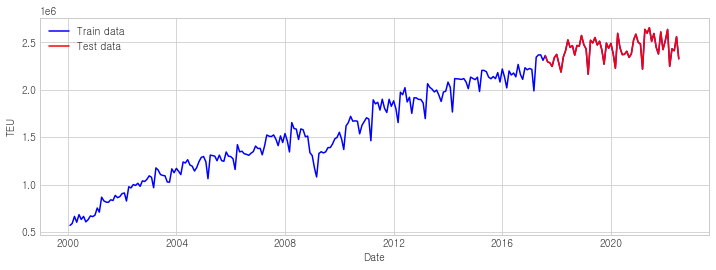

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [9]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [11]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [12]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [13]:
raw_df = data

In [14]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

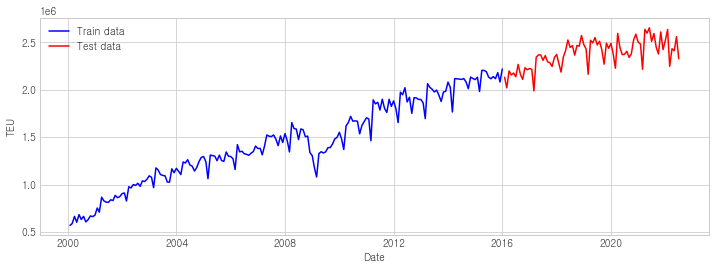

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [16]:
len(train),len(test)

(192, 78)

In [17]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [19]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [20]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 36   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [21]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [22]:
X_train.shape,Y_train.shape

((139, 18, 10), (139, 36, 1))

### 2. X_test,Y_test 배열

In [23]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_test.shape,Y_test.shape

((25, 18, 10), (25, 36, 1))

In [25]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [26]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal',name='extractor'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())
model.add(RepeatVector(36)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 9s 424ms/step - loss: 0.3985 - mae: 0.5308 - val_loss: 0.4326 - val_mae: 0.5945
Epoch 2/200
14/14 [==============================] - 0s 34ms/step - loss: 0.2823 - mae: 0.4559 - val_loss: 0.4491 - val_mae: 0.6117
Epoch 3/200
14/14 [==============================] - 0s 32ms/step - loss: 0.1525 - mae: 0.3176 - val_loss: 0.1552 - val_mae: 0.3286
Epoch 4/200
14/14 [==============================] - 0s 30ms/step - loss: 0.1066 - mae: 0.2621 - val_loss: 0.2065 - val_mae: 0.4019
Epoch 5/200
14/14 [==============================] - 0s 34ms/step - loss: 0.0847 - mae: 0.2327 - val_loss: 0.1095 - val_mae: 0.2765
Epoch 6/200
14/14 [==============================] - 1s 48ms/step - loss: 0.0664 - mae: 0.2049 - val_loss: 0.1166 - val_mae: 0.2963
Epoch 7/200
14/14 [==============================] - 1s 44ms/step - loss: 0.0557 - mae: 0.1854 - val_loss: 0.1032 - val_mae: 0.2692
Epoch 8/200
14/14 [==============================] - 1s 47ms/step - loss: 0

In [27]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

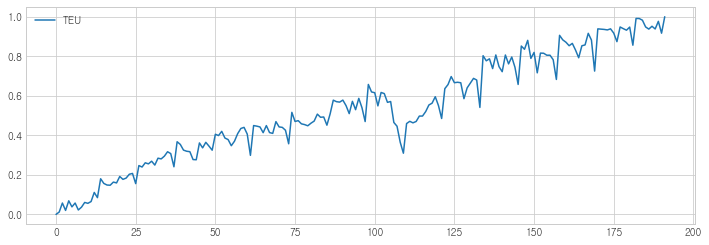

In [28]:
label_train.plot()

<AxesSubplot:>

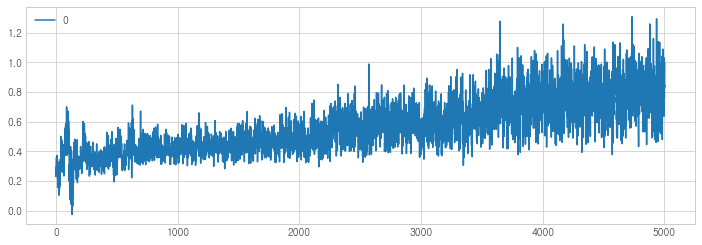

In [29]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 1. 2017.07 ~ 2020.06

In [30]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [31]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [32]:
dfs = [] # List 
for i in range(30): 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

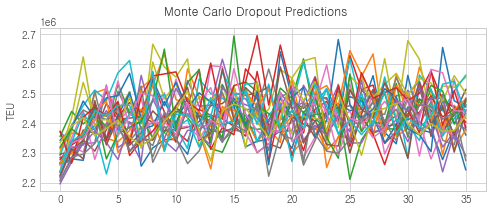

In [33]:
rcParams['figure.figsize'] = 8, 3
plt.suptitle('Monte Carlo Dropout Predictions')
#plt.xlabel('2017.07 ~ 2020.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [34]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [35]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [36]:
np.mean(df.std()/df.mean())

0.03297942504286766

In [37]:
df.transpose().mean().mean()

2422489.0

In [38]:
df.to_csv('36개월1.csv')

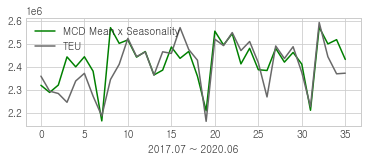

In [38]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.head(36).reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.head(36).reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2017.07 ~ 2020.06')
plt.legend(loc=2)

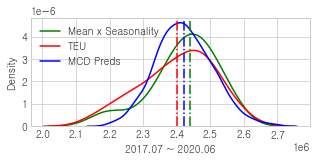

In [40]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.head(36).reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data.head(36),hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2422395.734629659,color='blue',linestyle='dashdot')
plt.axvline(2440384.4607475973,color='green',linestyle='dashdot')
plt.axvline(test_data.head(36).mean(),color='red',linestyle='dashdot')
plt.xlabel('2017.07 ~ 2020.06')
plt.legend(loc=2)

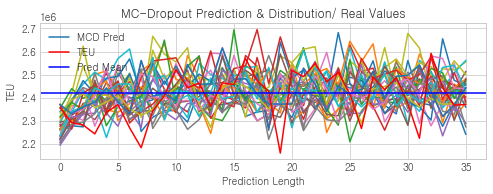

In [119]:
plt.figure(figsize=(8,2.5))
plt.title('MC-Dropout Prediction & Distribution/ Real Values')
plt.ylabel('TEU')
plt.xlabel('Prediction Length')
plt.plot(df)
plt.plot(df[4],label='MCD Pred')
plt.plot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU')
plt.axhline(df.transpose().mean().mean(),color='blue',label='Pred Mean')
plt.legend()

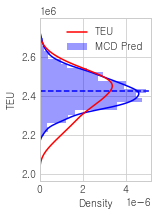

In [118]:
plt.figure(figsize=(2,3))
sns.distplot(df, vertical=True,color='blue',hist=True,label='MCD Pred')
sns.distplot(test_data.head(36).reset_index()['TEU'], vertical=True,color='red',hist=False,label='TEU')
plt.axhline(df.transpose().mean().mean(),color='blue',linestyle='dashed')
plt.legend()

In [37]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 41685.89081983321
MAPE: 1.3009513031149385


In [38]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 40377.14914676574
MAPE: 1.2708558206757616


In [39]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.head(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2220272.25,2282682.25,2267311.0,2263548.5,2370601.25,2284687.0,2317829.75,2205593.0,2301098.25,2291362.0,2262844.75,2312839.0,2354860.75,2276674.0,2195433.25,2295109.5,2258190.75,2233734.5,2237015.25,2263514.75,2341998.25,2266569.0,2318815.25,2373149.25,2215142.0,2224081.75,2235782.5,2206451.0,2334314.0,2235134.0


In [40]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 104734.12584787278
Mean MAPE: 3.468334925546611


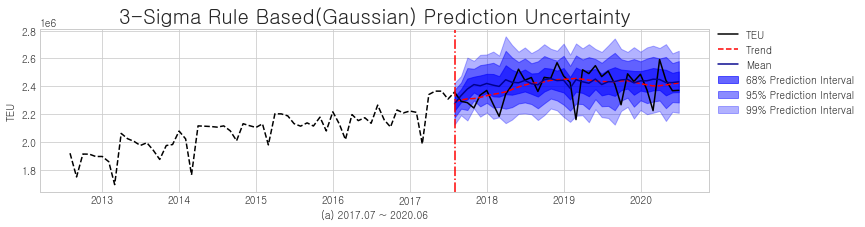

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().mean())/ test_data.head(36).reset_index()['TEU'])*100) )

In [42]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8611111111111112

In [43]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.9166666666666666

Median RMSE: 104051.33786119649
Median MAPE: 3.46629971410357


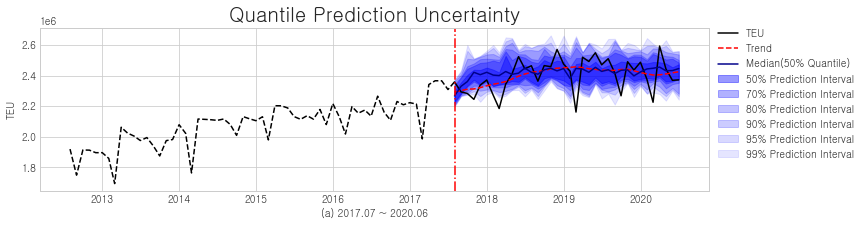

In [42]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().median())/ test_data.head(36).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.7777777777777778

In [46]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.8888888888888888

In [47]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 155085.7
Quantile 70% Interval Sharpness 150343.14062499994


In [48]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8055555555555556

In [49]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 310171.44
Quantile 95% Interval Sharpness 272098.82430555555
Min Max Interval Sharpness 317793.9


In [50]:
import CRPS.CRPS as pscore

In [51]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

57437.91249999999
22222.136111111115
60183.60805555556
137089.16277777782
37985.763611111106
29629.07805555556
92963.54944444446
174148.2024999999
57303.105555555565
16915.405555555553
64928.20277777779
15603.786666666667
31957.162499999995
29555.455833333337
25618.581666666665
17517.634444444448
89359.50166666666
24989.823888888888
31054.799444444438
240472.72194444438
48840.19111111112
45880.224166666674
61666.08611111111
33879.16138888889
45754.993055555555
22354.263888888887
136702.35194444444
26291.61416666667
26718.21305555556
31274.146111111113
40021.962499999994
180714.7613888889
101446.77638888889
24375.110277777778
32958.619999999995
43404.64277777777


In [52]:
a = np.array([57437.91249999999,
22222.136111111115,
60183.60805555556,
137089.16277777782,
37985.763611111106,
29629.07805555556,
92963.54944444446,
174148.2024999999,
57303.105555555565,
16915.405555555553,
64928.20277777779,
15603.786666666667,
31957.162499999995,
29555.455833333337,
25618.581666666665,
17517.634444444448,
89359.50166666666,
24989.823888888888,
31054.799444444438,
240472.72194444438,
48840.19111111112,
45880.224166666674,
61666.08611111111,
33879.16138888889,
45754.993055555555,
22354.263888888887,
136702.35194444444,
26291.61416666667,
26718.21305555556,
31274.146111111113,
40021.962499999994,
180714.7613888889,
101446.77638888889,
24375.110277777778,
32958.619999999995,
43404.64277777777])

In [53]:
np.mean(a)

59978.29759259259

In [41]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess,df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2422617.5

In [40]:
weight

2422617.5

In [39]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

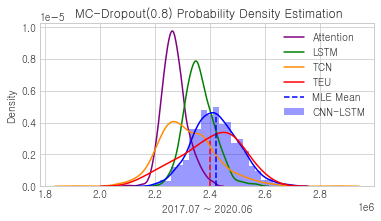

In [50]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.head(36).mean(), ymax=0.3, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.45, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2020.06')
plt.legend()

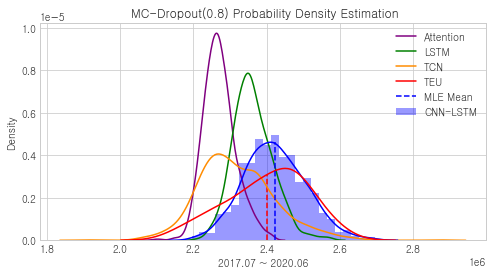

In [49]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.head(36).mean(), ymax=0.3, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.45, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2020.06')
plt.legend()

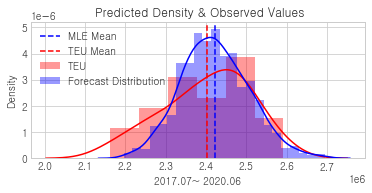

In [43]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2020.06')
plt.legend()

In [43]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(36).reset_index()['TEU'].mean(), scale=test_data.head(36).reset_index()['TEU'].std() ) )
LL

13862.484296688708

In [44]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

15419.957280836008

In [49]:
LL = -np.sum( stats.norm.logpdf(test_data.head(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

582.8095714703135

In [38]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [39]:
for i in range(0,30):
    print(KL(df[i],test_data.head(36).reset_index()['TEU']))

682283.2836795005
1196179.9876357026
596874.5634317603
1253555.7053102395
1249660.2041537205
920668.4245851659
321970.8287982217
485345.05892383534
3429780.8203465426
2600031.806613671
368718.088376447
37400.81508576849
922836.8163151243
117537.8266622196
109026.1963160811
516173.8593180336
802350.09515621
349822.4406659649
2437877.7262700163
512820.9931401627
2392244.7651453256
1690172.2549659
1302885.1637000777
3091189.8719890513
4946.023804064331
745952.6191052689
808421.5052780365
1258811.0615569274
277877.9269589508
895358.8523302494


In [61]:
a = np.array([682283.2836795005,
1196179.9876357026,
596874.5634317603,
1253555.7053102395,
1249660.2041537205,
920668.4245851659,
321970.8287982217,
485345.05892383534,
3429780.8203465426,
2600031.806613671,
368718.088376447,
37400.81508576849,
922836.8163151243,
117537.8266622196,
109026.1963160811,
516173.8593180336,
802350.09515621,
349822.4406659649,
2437877.7262700163,
512820.9931401627,
2392244.7651453256,
1690172.2549659,
1302885.1637000777,
3091189.8719890513,
4946.023804064331,
745952.6191052689,
808421.5052780365,
1258811.0615569274,
277877.9269589508,
895358.8523302494])

In [62]:
np.mean(a)

1045959.1861872748

### Scenario Forecast 선정

In [42]:
mape = []

for i in range(0,30):
    a = np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[i])/ test_data.head(36).reset_index()['TEU'])*100) 
    mape.append(a)

In [43]:
pd.DataFrame(mape).sort_values(by=0).head(5)

,0
28,2.740282
15,3.589145
14,3.853009
13,3.907193
4,3.912950


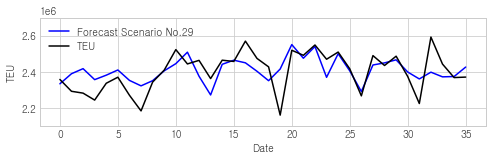

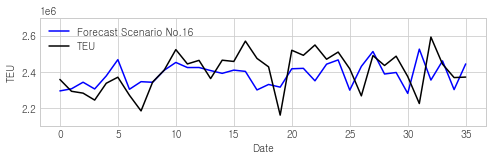

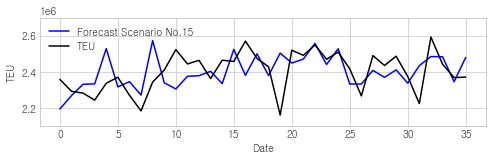

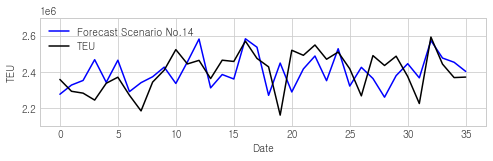

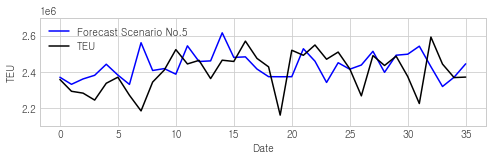

In [44]:
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[15],label='Forecast Scenario No.16',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[14],label='Forecast Scenario No.15',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[13],label='Forecast Scenario No.14',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

### Jensen Shannon Distance

In [45]:
import scipy.stats
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [46]:
scenario = []

for i in range(0,30):
    a = jensen_shannon_distance(df[i],df.transpose().mean()*seasonal['Seasonal'].head(36).reset_index()['Seasonal'])
    scenario.append(a)

In [47]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
28,0.013107
29,0.013669
14,0.014842
22,0.015505
27,0.015550


In [48]:
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[27])/ test_data.head(36).reset_index()['TEU'])*100))

MAPE: 4.152212992425016


RMSE: 116710.26234526103
MAPE: 3.8530090511193538
RMSE: 122366.18511307963
MAPE: 4.250337759770565
RMSE: 123994.26410962944
MAPE: 4.152212992425016
RMSE: 86106.16605413149
MAPE: 2.740282434472157
RMSE: 115162.95057984987
MAPE: 4.240499736888464


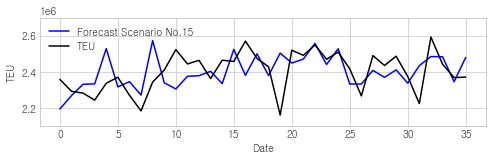

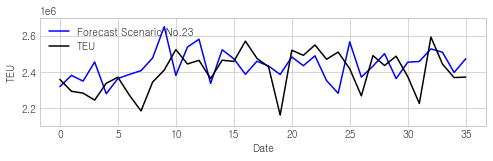

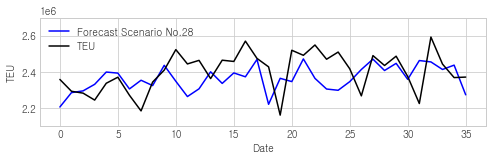

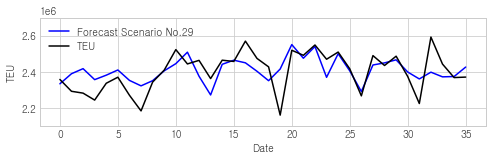

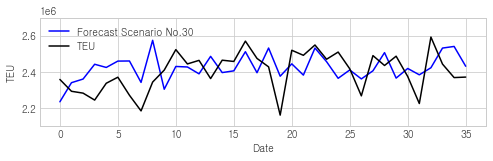

In [53]:
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[14],label='Forecast Scenario No.15',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[14]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[14])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[22],label='Forecast Scenario No.23',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[22]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[22])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[27],label='Forecast Scenario No.28',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[27]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[27])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[28]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[28])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[29],label='Forecast Scenario No.30',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[29]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[29])/ test_data.head(36).reset_index()['TEU'])*100))

In [50]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
28,0.013107
29,0.013669
14,0.014842
22,0.015505
27,0.015550


In [51]:
pd.concat([df[28],df[29],df[14],df[22],df[27]],axis=1).to_csv('1번.csv')

In [52]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,29,30,15,23,28
Date,,,,,
2017-07-31,2334314.0,2235134.0,2195433.2,2318815.2,2206451.0
2017-08-31,2389949.0,2340544.2,2269344.0,2380908.8,2285654.5
2017-09-30,2417897.8,2360605.5,2331836.5,2349098.2,2295380.2
2017-10-31,2357312.5,2442237.0,2333845.5,2454721.8,2331505.8
2017-11-30,2382003.0,2424637.8,2528592.5,2279646.0,2399230.2


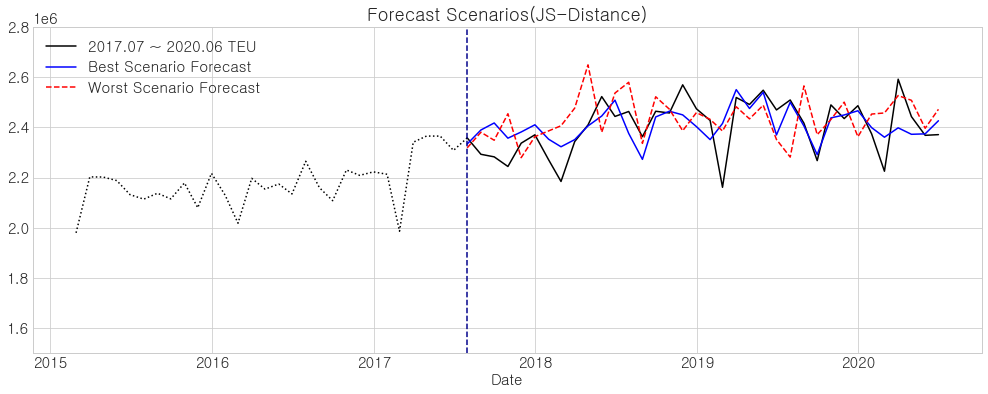

In [55]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(JS-Distance)',fontsize=18)
plt.ylim(1.5e6,2.8e6)
plt.plot(data['TEU'].iloc[181:211], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[210:246], 'black', label='2017.07 ~ 2020.06 TEU')
plt.plot(df3['29'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['23'],color='red',label='Worst Scenario Forecast',linestyle='dashed')

plt.axvline(x='2017-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [56]:
df3.head()

,29,30,15,23,28
Date,,,,,
2017-07-31,2334314.0,2235134.0,2195433.2,2318815.2,2206451.0
2017-08-31,2389949.0,2340544.2,2269344.0,2380908.8,2285654.5
2017-09-30,2417897.8,2360605.5,2331836.5,2349098.2,2295380.2
2017-10-31,2357312.5,2442237.0,2333845.5,2454721.8,2331505.8
2017-11-30,2382003.0,2424637.8,2528592.5,2279646.0,2399230.2


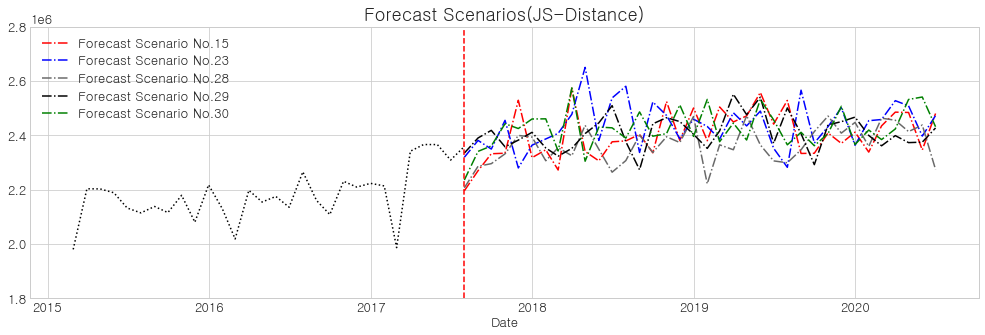

In [58]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(JS-Distance)',fontsize=18)
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[181:211], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[210:246], 'black', label='2017.07 ~ 2020.06 TEU')
plt.plot(df3['15'],color='red',label='Forecast Scenario No.15',linestyle='dashdot')
plt.plot(df3['23'],color='blue',label='Forecast Scenario No.23',linestyle='dashdot')
plt.plot(df3['28'],color='dimgrey',label='Forecast Scenario No.28',linestyle='dashdot')
plt.plot(df3['29'],color='black',label='Forecast Scenario No.29',linestyle='dashdot')
plt.plot(df3['30'],color='green',label='Forecast Scenario No.30',linestyle='dashdot')

plt.axvline(x='2017-07-31', color='red',linestyle='dashed')
plt.legend()

### Euclidean Distance

In [54]:
scenario = []

for i in range(0,30):
    a = np.linalg.norm(df[i]-df.transpose().mean()*seasonal['Seasonal'].head(36).reset_index()['Seasonal'])
    scenario.append(a)

In [55]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
28,540784.483184
29,557877.714172
14,615793.077349
5,636497.302839
2,638276.977585


In [58]:
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[2])/ test_data.head(36).reset_index()['TEU'])*100))

MAPE: 3.922470387742699


RMSE: 117138.94695301139
MAPE: 3.922470387742699
RMSE: 112448.39148465446
MAPE: 3.917782521844439
RMSE: 116710.26234526103
MAPE: 3.8530090511193538
RMSE: 86106.16605413149
MAPE: 2.740282434472157
RMSE: 115162.95057984987
MAPE: 4.240499736888464


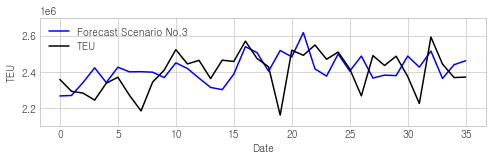

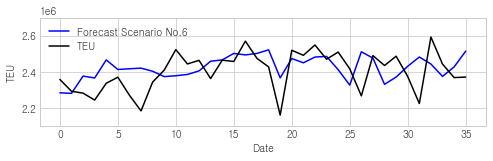

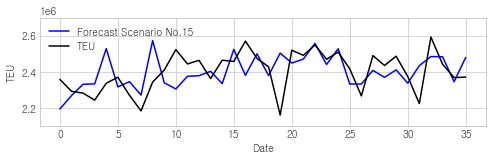

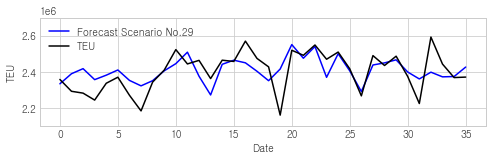

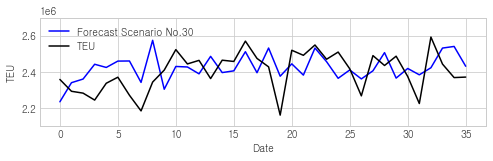

In [47]:
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[2],label='Forecast Scenario No.3',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[2]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[2])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[5]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[5])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[14],label='Forecast Scenario No.15',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[14]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[14])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[28]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[28])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[29],label='Forecast Scenario No.30',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[29]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[29])/ test_data.head(36).reset_index()['TEU'])*100))

In [49]:
pd.concat([df[2],df[5],df[14],df[28],df[29]],axis=1).to_csv('1번.csv')

In [50]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,3,6,15,29,30
Date,,,,,
2017-07-31,2267311.0,2284687.0,2195433.2,2334314.0,2235134.0
2017-08-31,2270005.8,2281619.0,2269344.0,2389949.0,2340544.2
2017-09-30,2341704.8,2376940.8,2331836.5,2417897.8,2360605.5
2017-10-31,2422619.2,2366601.2,2333845.5,2357312.5,2442237.0
2017-11-30,2341187.8,2466208.8,2528592.5,2382003.0,2424637.8


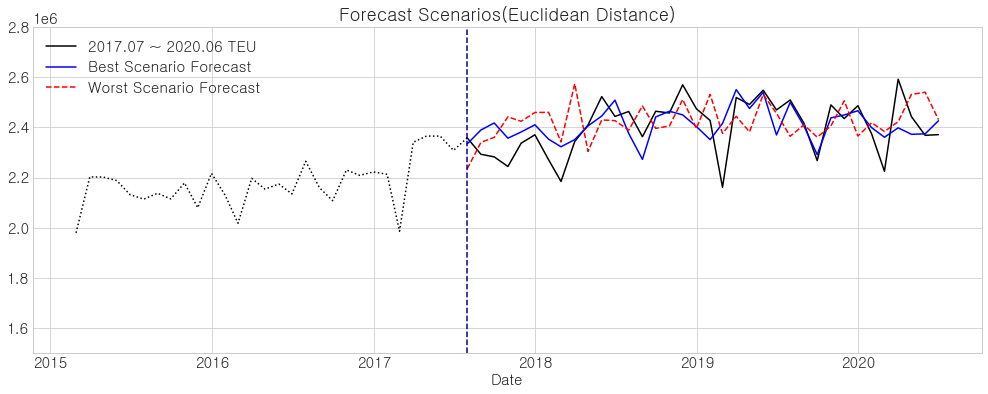

In [51]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Euclidean Distance)',fontsize=18)
plt.ylim(1.5e6,2.8e6)
plt.plot(data['TEU'].iloc[181:211], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[210:246], 'black', label='2017.07 ~ 2020.06 TEU')
plt.plot(df3['29'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['30'],color='red',label='Worst Scenario Forecast',linestyle='dashed')

plt.axvline(x='2017-07-31', color='darkblue',linestyle='dashed')
plt.legend()

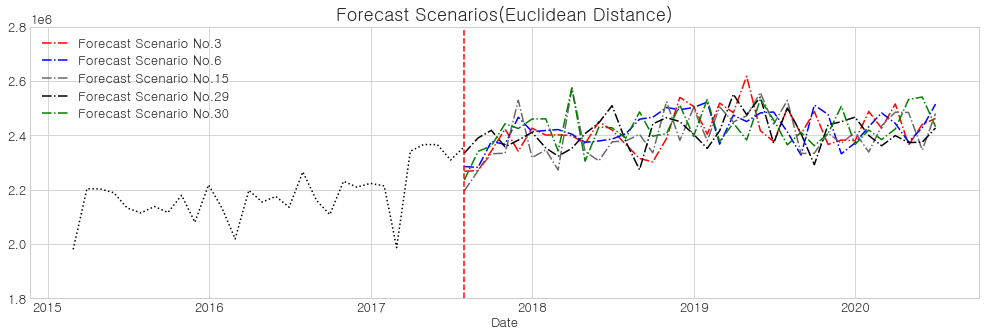

In [52]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Euclidean Distance)',fontsize=18)
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[181:211], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[210:246], 'black', label='2017.07 ~ 2020.06 TEU')
plt.plot(df3['3'],color='red',label='Forecast Scenario No.3',linestyle='dashdot')
plt.plot(df3['6'],color='blue',label='Forecast Scenario No.6',linestyle='dashdot')
plt.plot(df3['15'],color='dimgrey',label='Forecast Scenario No.15',linestyle='dashdot')
plt.plot(df3['29'],color='black',label='Forecast Scenario No.29',linestyle='dashdot')
plt.plot(df3['30'],color='green',label='Forecast Scenario No.30',linestyle='dashdot')

plt.axvline(x='2017-07-31', color='red',linestyle='dashed')
plt.legend()

### Dynamic Time Warping

In [60]:
from dtaidistance import dtw

In [61]:
scenario = []

for i in range(0,30):
    a = dtw.distance(df[i], df.transpose().mean()*seasonal['Seasonal'].head(36).reset_index()['Seasonal'])
    scenario.append(a)

In [62]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
11,388990.766580
28,398807.407638
10,404370.978974
25,405998.600558
19,410616.716110


In [67]:
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[19])/ test_data.head(36).reset_index()['TEU'])*100))

MAPE: 4.47079229382905


RMSE: 127463.07684910958
MAPE: 4.203396055322796
RMSE: 125842.22445939554
MAPE: 4.285725017939601
RMSE: 125966.5400597378
MAPE: 4.47079229382905
RMSE: 135913.04817889186
MAPE: 4.26920011825786
RMSE: 86106.16605413149
MAPE: 2.740282434472157


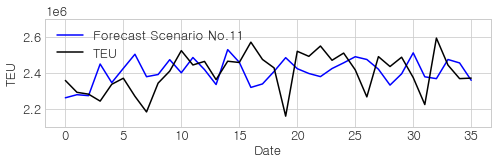

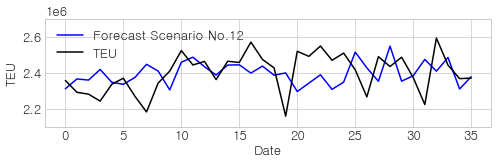

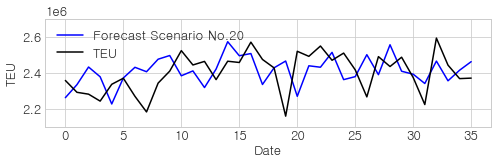

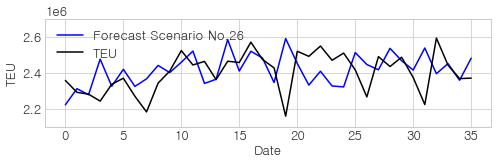

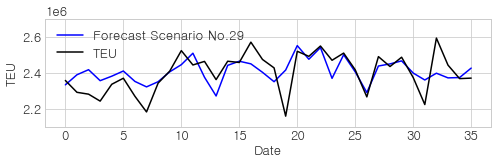

In [58]:
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[10],label='Forecast Scenario No.11',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[10]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[10])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[11],label='Forecast Scenario No.12',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[11]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[11])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[19],label='Forecast Scenario No.20',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[19]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[19])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[25],label='Forecast Scenario No.26',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[25]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[25])/ test_data.head(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(test_data.head(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df[28]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df[28])/ test_data.head(36).reset_index()['TEU'])*100))

In [59]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
11,388990.766580
28,398807.407638
10,404370.978974
25,405998.600558
19,410616.716110


In [60]:
pd.concat([df[10],df[11],df[19],df[25],df[28]],axis=1).to_csv('1번.csv')

In [63]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,11,12,20,26,29
Date,,,,,
2017-07-31,2262844.8,2312839.0,2263514.8,2224081.8,2334314.0
2017-08-31,2279899.5,2366861.0,2335374.8,2313144.8,2389949.0
2017-09-30,2274692.2,2360473.0,2432705.2,2279713.2,2417897.8
2017-10-31,2449169.0,2419356.8,2378786.5,2476108.8,2357312.5
2017-11-30,2346442.2,2348713.8,2228703.0,2326564.2,2382003.0


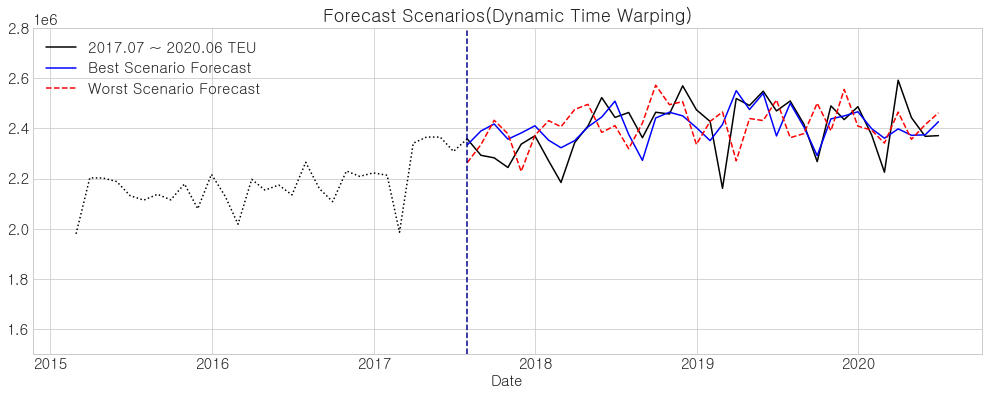

In [64]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Dynamic Time Warping)',fontsize=18)
plt.ylim(1.5e6,2.8e6)
plt.plot(data['TEU'].iloc[181:211], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[210:246], 'black', label='2017.07 ~ 2020.06 TEU')
plt.plot(df3['29'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['20'],color='red',label='Worst Scenario Forecast',linestyle='dashed')

plt.axvline(x='2017-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [65]:
df3.head()

,11,12,20,26,29
Date,,,,,
2017-07-31,2262844.8,2312839.0,2263514.8,2224081.8,2334314.0
2017-08-31,2279899.5,2366861.0,2335374.8,2313144.8,2389949.0
2017-09-30,2274692.2,2360473.0,2432705.2,2279713.2,2417897.8
2017-10-31,2449169.0,2419356.8,2378786.5,2476108.8,2357312.5
2017-11-30,2346442.2,2348713.8,2228703.0,2326564.2,2382003.0


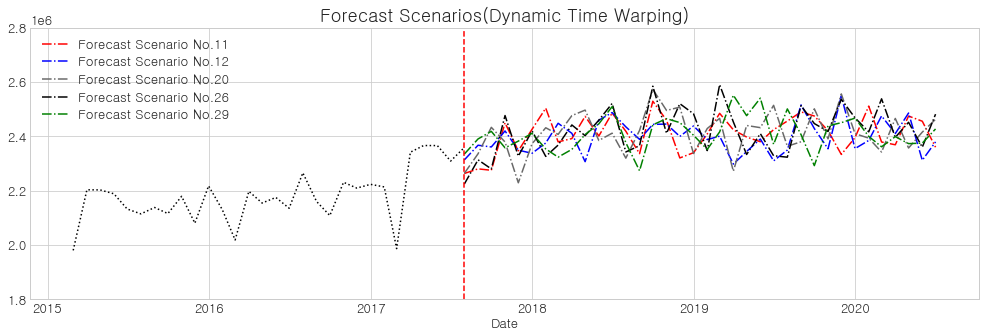

In [66]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Dynamic Time Warping)',fontsize=18)
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[181:211], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[210:246], 'black', label='2017.07 ~ 2020.06 TEU')
plt.plot(df3['11'],color='red',label='Forecast Scenario No.11',linestyle='dashdot')
plt.plot(df3['12'],color='blue',label='Forecast Scenario No.12',linestyle='dashdot')
plt.plot(df3['20'],color='dimgrey',label='Forecast Scenario No.20',linestyle='dashdot')
plt.plot(df3['26'],color='black',label='Forecast Scenario No.26',linestyle='dashdot')
plt.plot(df3['29'],color='green',label='Forecast Scenario No.29',linestyle='dashdot')

plt.axvline(x='2017-07-31', color='red',linestyle='dashed')
plt.legend()

### 2. 2019.07 ~ 2022.06

In [39]:
X_test_2 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

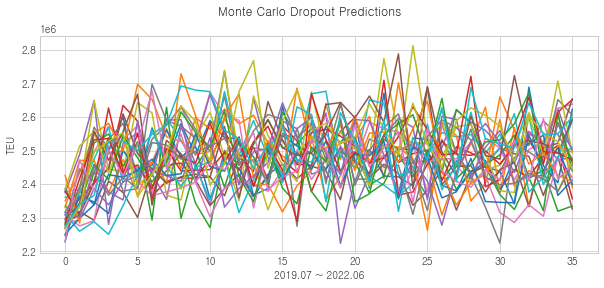

In [40]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2022.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [41]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [42]:
np.mean(df.std()/df.mean())

0.03718890994787216

In [43]:
df.to_csv('36개월2.csv')

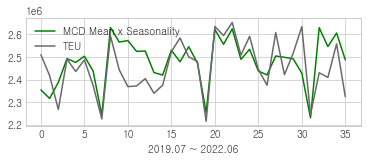

In [43]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.tail(36).reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.tail(36).reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2019.07 ~ 2022.06')
plt.legend(loc=2)

In [48]:
(df.transpose().mean()*seasonal.tail(36).reset_index()['Seasonal']).mean()

2479318.8216857444

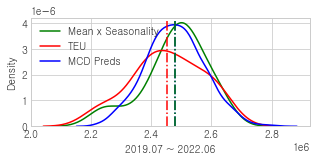

In [50]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.tail(36).reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data.tail(36),hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2479814.2,color='blue',linestyle='dashdot')
plt.axvline(2479318.8216857444,color='green',linestyle='dashdot')
plt.axvline(test_data.tail(36).mean(),color='red',linestyle='dashdot')
plt.xlabel('2019.07 ~ 2022.06')
plt.legend(loc=2)

In [55]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().mean())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 49986.34301066608
MAPE: 1.6326077298030097


In [56]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 49204.299581819585
MAPE: 1.6105175778730907


In [56]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.tail(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2229789.0,2350151.25,2335775.5,2308579.0,2374326.0,2278336.5,2378292.75,2293002.0,2275083.75,2361164.75,2246858.5,2329891.0,2386970.75,2379723.25,2280263.0,2287276.5,2307976.25,2317247.5,2384758.5,2311456.25,2251408.5,2426738.0,2268182.0,2281723.5,2316477.75,2297328.5,2227099.75,2268045.75,2268138.75,2273374.0


In [57]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
#data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 123919.03538697993
Mean MAPE: 4.274833983382819


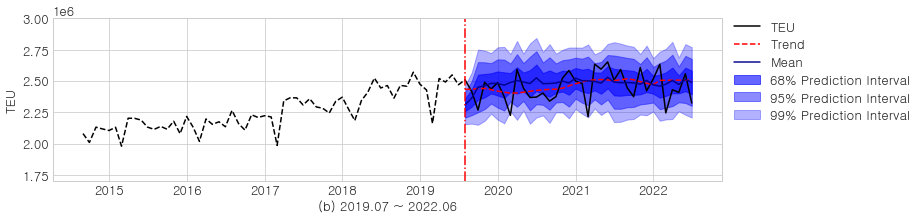

In [67]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,3.0e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [73]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8888888888888888


In [74]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

추세 변동에 대한 포함확률: 0.8888888888888888


Median RMSE: 124790.2734074213
Median MAPE: 4.319736379944547


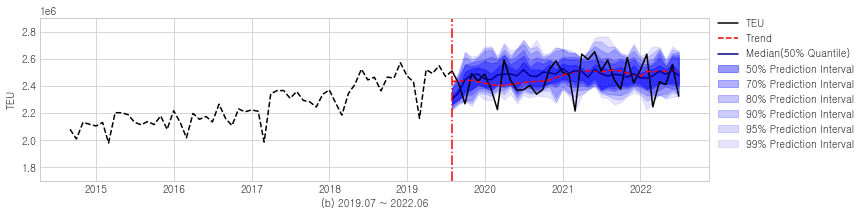

In [75]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().median())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [76]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.75

In [77]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.9166666666666666

In [78]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 178231.66
Quantile 70% Interval Sharpness 176305.4878472222


In [69]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8055555555555556

In [80]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 356463.38
Quantile 95% Interval Sharpness 312399.65746527776
Min Max Interval Sharpness 360884.53


In [81]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

171203.96555555554
38191.03222222222
126714.76472222221
24243.074999999997
28420.36055555555
26268.178333333333
47975.58388888889
219497.37611111114
54926.92527777777
27191.06638888888
68235.06444444443
98308.78972222222
42408.60166666667
84345.70416666665
68892.40555555555
27304.246944444443
65404.59944444445
23024.056111111113
20850.82083333333
232755.0958333333
97882.4175
77650.59333333334
88105.6911111111
25145.731666666663
71238.70694444445
32225.41527777778
68056.02944444446
90308.01249999998
42031.03194444445
31049.54444444444
126405.39527777777
177997.56194444443
42877.43055555557
40966.50194444444
32716.364999999998
112750.97805555559


In [82]:
a = np.array([171203.96555555554,
38191.03222222222,
126714.76472222221,
24243.074999999997,
28420.36055555555,
26268.178333333333,
47975.58388888889,
219497.37611111114,
54926.92527777777,
27191.06638888888,
68235.06444444443,
98308.78972222222,
42408.60166666667,
84345.70416666665,
68892.40555555555,
27304.246944444443,
65404.59944444445,
23024.056111111113,
20850.82083333333,
232755.0958333333,
97882.4175,
77650.59333333334,
88105.6911111111,
25145.731666666663,
71238.70694444445,
32225.41527777778,
68056.02944444446,
90308.01249999998,
42031.03194444445,
31049.54444444444,
126405.39527777777,
177997.56194444443,
42877.43055555557,
40966.50194444444,
32716.364999999998,
112750.97805555559])

In [83]:
np.mean(a)

73710.25332561729

In [44]:
for i in range(0,30):
    print(KL(df[i],test_data.tail(36).reset_index()['TEU']))

1242635.9948365833
1742660.4488599587
511890.66113054566
638823.9401869558
1436360.743115769
1524441.3567297535
2400037.6585759935
1767342.7394599132
2058542.3890600873
1612207.2645295337
332652.7883101484
684464.1350989831
478528.60171904205
1344065.959946071
1050011.8729756451
913719.5354178789
1416070.0230764912
1820246.5633039642
1865724.5253434519
241190.744508654
578128.7715626581
2366398.344028287
1377531.1348916222
1606967.6065525068
600660.9123114457
2787034.8729476547
558369.1177386303
860152.4782268093
3025806.2288604705
2782576.1106731375


In [45]:
a = np.array([1242635.9948365833,
1742660.4488599587,
511890.66113054566,
638823.9401869558,
1436360.743115769,
1524441.3567297535,
2400037.6585759935,
1767342.7394599132,
2058542.3890600873,
1612207.2645295337,
332652.7883101484,
684464.1350989831,
478528.60171904205,
1344065.959946071,
1050011.8729756451,
913719.5354178789,
1416070.0230764912,
1820246.5633039642,
1865724.5253434519,
241190.744508654,
578128.7715626581,
2366398.344028287,
1377531.1348916222,
1606967.6065525068,
600660.9123114457,
2787034.8729476547,
558369.1177386303,
860152.4782268093,
3025806.2288604705,
2782576.1106731375])

In [46]:
np.mean(a)

1387508.1174659545

In [61]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess,df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2479814.2

In [57]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

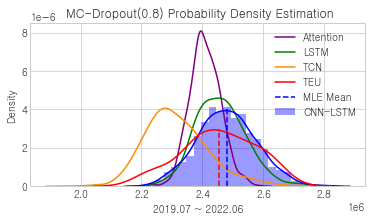

In [70]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.tail(36).mean(), ymax=0.35, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.tail(36).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.48, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2019.07 ~ 2022.06')
plt.legend()

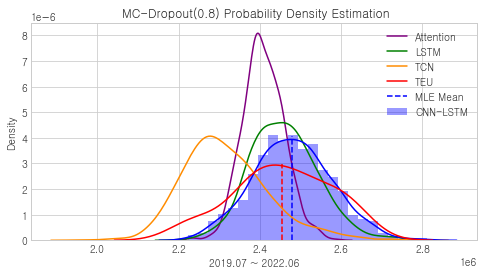

In [69]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.tail(36).mean(), ymax=0.35, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.tail(36).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.48, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2019.07 ~ 2022.06')
plt.legend()

### Scenario Forecast

In [68]:
mape = []

for i in range(0,30):
    a = np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[i])/ test_data.tail(36).reset_index()['TEU'])*100) 
    mape.append(a)

In [69]:
pd.DataFrame(mape).sort_values(by=0).head(5)

,0
16,3.914592
5,4.003100
24,4.015919
3,4.131076
20,4.338374


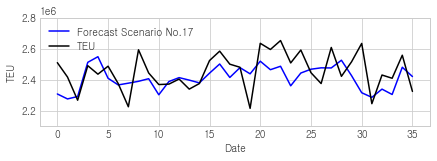

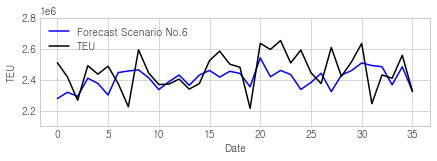

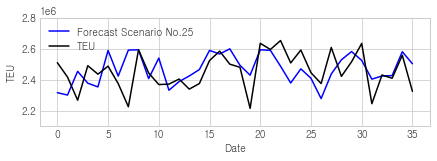

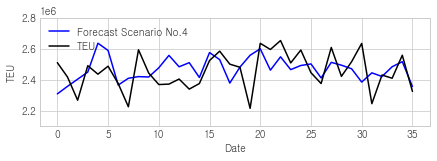

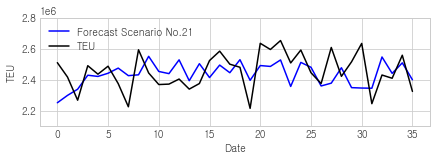

In [70]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[24],label='Forecast Scenario No.25',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[3],label='Forecast Scenario No.4',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[20],label='Forecast Scenario No.21',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

### Jensen Shannon Distance

In [71]:
scenario = []

for i in range(0,30):
    a = jensen_shannon_distance(df[i],df.transpose().mean()*seasonal['Seasonal'].tail(36).reset_index()['Seasonal'])
    scenario.append(a)

In [72]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
20,0.012044
6,0.013709
0,0.014641
16,0.014931
5,0.015454


RMSE: 146223.33698411172
MAPE: 4.839739437864789
RMSE: 125834.15733369143
MAPE: 4.003099556615484
RMSE: 147200.5128281009
MAPE: 4.947356568329145
RMSE: 118919.4110574322
MAPE: 3.914591835218035
RMSE: 124796.63693148835
MAPE: 4.3383741075173425


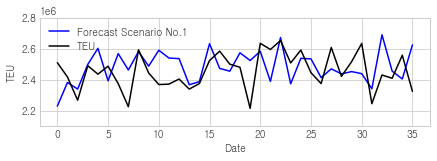

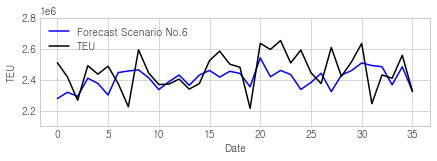

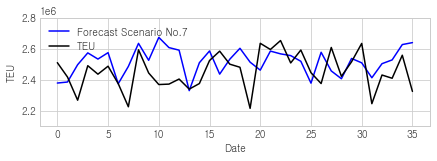

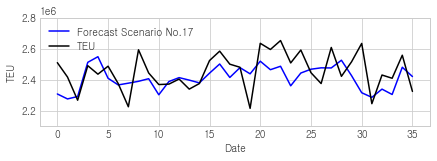

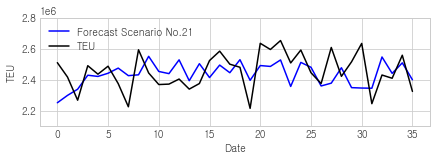

In [73]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[0],label='Forecast Scenario No.1',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[0])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[5]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[5])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[6]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[6])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[16]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[16])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[20],label='Forecast Scenario No.21',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[20]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[20])/ test_data.tail(36).reset_index()['TEU'])*100) )

In [74]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
20,0.012044
6,0.013709
0,0.014641
16,0.014931
5,0.015454


In [75]:
pd.concat([df[20],df[6],df[0],df[16],df[5]],axis=1).to_csv('1번.csv')

In [77]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,21,7,1,17,6
Date,,,,,
2019-07-31,2251408.5,2378292.8,2229789.0,2307976.2,2278336.5
2019-08-31,2298761.0,2384878.8,2382029.0,2276000.5,2318970.5
2019-09-30,2338595.0,2496325.0,2339451.2,2291553.5,2292631.8
2019-10-31,2428727.5,2572532.5,2498400.0,2511705.8,2409554.2
2019-11-30,2420870.2,2532684.5,2601882.2,2547879.5,2375346.8


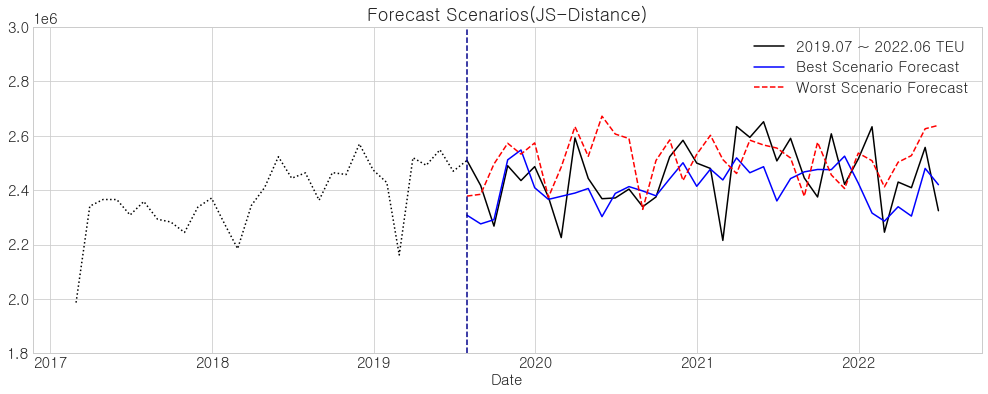

In [78]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(JS-Distance)',fontsize=18)
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[205:235], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[234:], 'black', label='2019.07 ~ 2022.06 TEU')
plt.plot(df3['17'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['7'],color='red',label='Worst Scenario Forecast',linestyle='dashed')


plt.axvline(x='2019-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [79]:
df3.head(1)

,21,7,1,17,6
Date,,,,,
2019-07-31,2251408.5,2378292.8,2229789.0,2307976.2,2278336.5


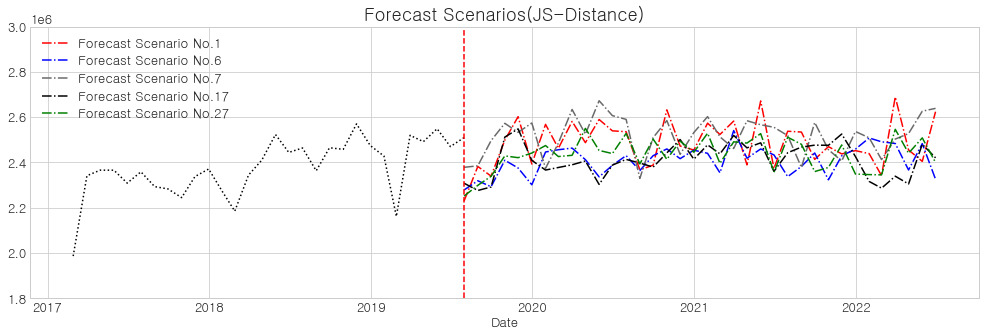

In [80]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(JS-Distance)',fontsize=18)
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[205:235], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[234:], 'black', label='2019.07 ~ 2022.06 TEU')
plt.plot(df3['1'],color='red',label='Forecast Scenario No.1',linestyle='dashdot')
plt.plot(df3['6'],color='blue',label='Forecast Scenario No.6',linestyle='dashdot')
plt.plot(df3['7'],color='dimgrey',label='Forecast Scenario No.7',linestyle='dashdot')
plt.plot(df3['17'],color='black',label='Forecast Scenario No.17',linestyle='dashdot')
plt.plot(df3['21'],color='green',label='Forecast Scenario No.27',linestyle='dashdot')

plt.axvline(x='2019-07-31', color='red',linestyle='dashed')
plt.legend()

### Euclidean Distance

In [87]:
scenario = []

for i in range(0,30):
    a = np.linalg.norm(df[i]-df.transpose().mean()*seasonal['Seasonal'].tail(36).reset_index()['Seasonal'])
    scenario.append(a)

In [88]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
20,567127.360067
0,612222.218386
6,615392.416114
3,649793.235769
24,679009.553732


In [93]:
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[24])/ test_data.tail(36).reset_index()['TEU'])*100) )

MAPE: 4.015918667569823


RMSE: 146223.33698411172
MAPE: 4.839739437864789
RMSE: 125858.34761220096
MAPE: 4.131076395477598
RMSE: 147200.5128281009
MAPE: 4.947356568329145
RMSE: 124796.63693148835
MAPE: 4.3383741075173425
RMSE: 122886.16385317895
MAPE: 4.015918667569823


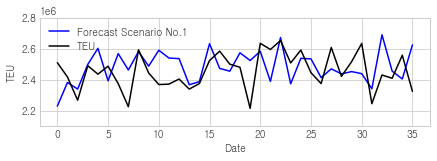

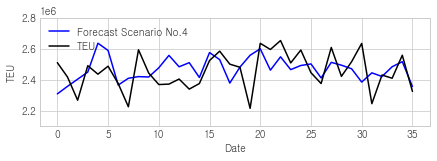

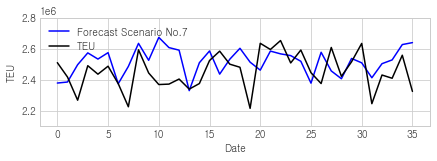

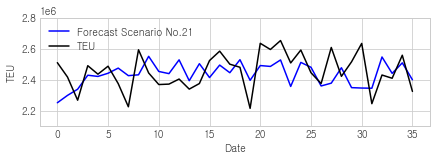

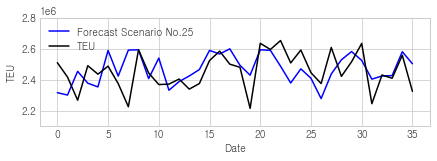

In [86]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[0],label='Forecast Scenario No.1',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[0])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[3],label='Forecast Scenario No.4',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[3]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[3])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[6]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[6])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[20],label='Forecast Scenario No.21',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[20]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[20])/ test_data.tail(36).reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2019.07 ~ 2022.06')
plt.plot(df[24],label='Forecast Scenario No.25',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[24]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[24])/ test_data.tail(36).reset_index()['TEU'])*100) )

In [87]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
20,567127.360067
0,612222.218386
6,615392.416114
3,649793.235769
24,679009.553732


In [88]:
pd.concat([df[0],df[3],df[6],df[20],df[24]],axis=1).to_csv('1번.csv')

In [89]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,1,4,7,21,25
Date,,,,,
2019-07-31,2229789.0,2308579.0,2378292.8,2251408.5,2316477.8
2019-08-31,2382029.0,2356927.0,2384878.8,2298761.0,2300996.5
2019-09-30,2339451.2,2403074.2,2496325.0,2338595.0,2453670.8
2019-10-31,2498400.0,2449005.2,2572532.5,2428727.5,2377358.0
2019-11-30,2601882.2,2634662.2,2532684.5,2420870.2,2353352.8


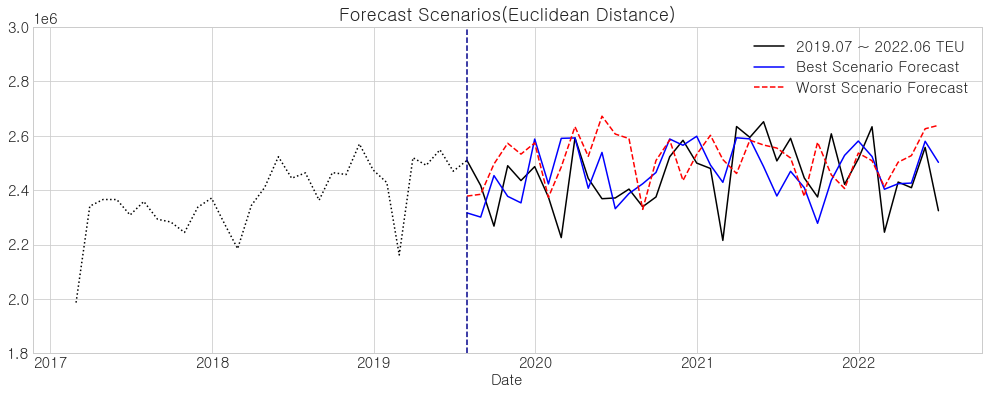

In [96]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Euclidean Distance)',fontsize=18)
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[205:235], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[234:], 'black', label='2019.07 ~ 2022.06 TEU')
plt.plot(df3['25'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['7'],color='red',label='Worst Scenario Forecast',linestyle='dashed')


plt.axvline(x='2019-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [97]:
df3.head()

,1,4,7,21,25
Date,,,,,
2019-07-31,2229789.0,2308579.0,2378292.8,2251408.5,2316477.8
2019-08-31,2382029.0,2356927.0,2384878.8,2298761.0,2300996.5
2019-09-30,2339451.2,2403074.2,2496325.0,2338595.0,2453670.8
2019-10-31,2498400.0,2449005.2,2572532.5,2428727.5,2377358.0
2019-11-30,2601882.2,2634662.2,2532684.5,2420870.2,2353352.8


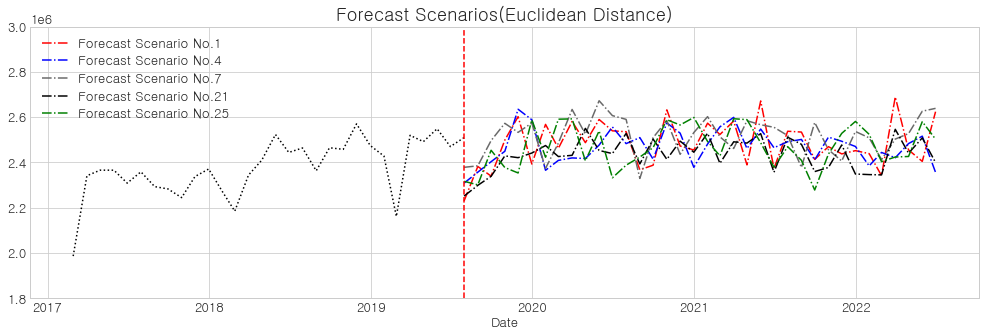

In [102]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Euclidean Distance)',fontsize=18)
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[205:235], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[234:], 'black', label='2019.07 ~ 2022.06 TEU')
plt.plot(df3['1'],color='red',label='Forecast Scenario No.1',linestyle='dashdot')
plt.plot(df3['4'],color='blue',label='Forecast Scenario No.4',linestyle='dashdot')
plt.plot(df3['7'],color='dimgrey',label='Forecast Scenario No.7',linestyle='dashdot')
plt.plot(df3['21'],color='black',label='Forecast Scenario No.21',linestyle='dashdot')
plt.plot(df3['25'],color='green',label='Forecast Scenario No.25',linestyle='dashdot')

plt.axvline(x='2019-07-31', color='red',linestyle='dashed')
plt.legend()

### Dynamic Time Warping

In [94]:
from dtaidistance import dtw

In [95]:
scenario = []

for i in range(0,30):
    a = dtw.distance(df[i], df.transpose().mean()*seasonal['Seasonal'].tail(36).reset_index()['Seasonal'])
    scenario.append(a)

In [96]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
17,401886.300653
12,423161.181771
20,423403.780104
24,431783.576240
11,435740.821516


In [101]:
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[11])/ test_data.tail(36).reset_index()['TEU'])*100))

MAPE: 4.735015642670817


RMSE: 133705.68927339875
MAPE: 4.735015642670817
RMSE: 156270.9708079318
MAPE: 5.059837639548863
RMSE: 204143.78216012087
MAPE: 6.765157763863267
RMSE: 124796.63693148835
MAPE: 4.3383741075173425
RMSE: 122886.16385317895
MAPE: 4.015918667569823


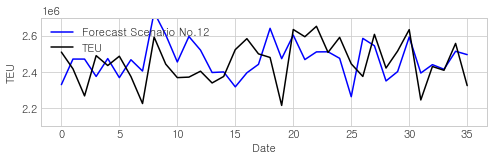

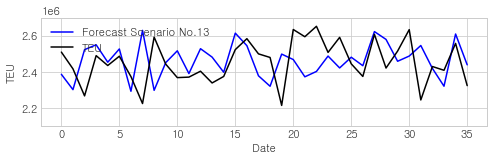

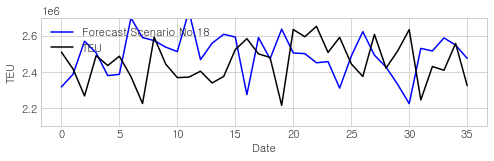

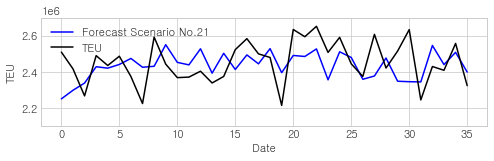

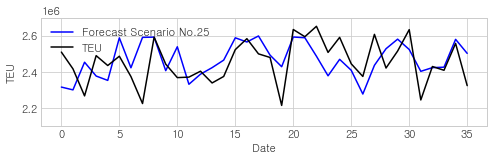

In [117]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[11],label='Forecast Scenario No.12',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[11]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[11])/ test_data.tail(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[12],label='Forecast Scenario No.13',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[12]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[12])/ test_data.tail(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[17],label='Forecast Scenario No.18',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[17]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[17])/ test_data.tail(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[20],label='Forecast Scenario No.21',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[20]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[20])/ test_data.tail(36).reset_index()['TEU'])*100))

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
plt.plot(df[24],label='Forecast Scenario No.25',color='blue')
plt.plot(test_data.tail(36).reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df[24]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df[24])/ test_data.tail(36).reset_index()['TEU'])*100))

In [114]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
17,401886.300653
12,423161.181771
20,423403.780104
24,431783.576240
11,435740.821516


In [115]:
pd.concat([df[11],df[12],df[17],df[20],df[24]],axis=1).to_csv('1번.csv')

In [116]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,12,13,18,21,25
Date,,,,,
2019-07-31,2329891.0,2386970.8,2317247.5,2251408.5,2316477.8
2019-08-31,2471098.5,2302355.2,2386617.0,2298761.0,2300996.5
2019-09-30,2470947.0,2522909.8,2569870.2,2338595.0,2453670.8
2019-10-31,2375121.2,2549877.0,2504931.2,2428727.5,2377358.0
2019-11-30,2473806.5,2453758.0,2379917.5,2420870.2,2353352.8


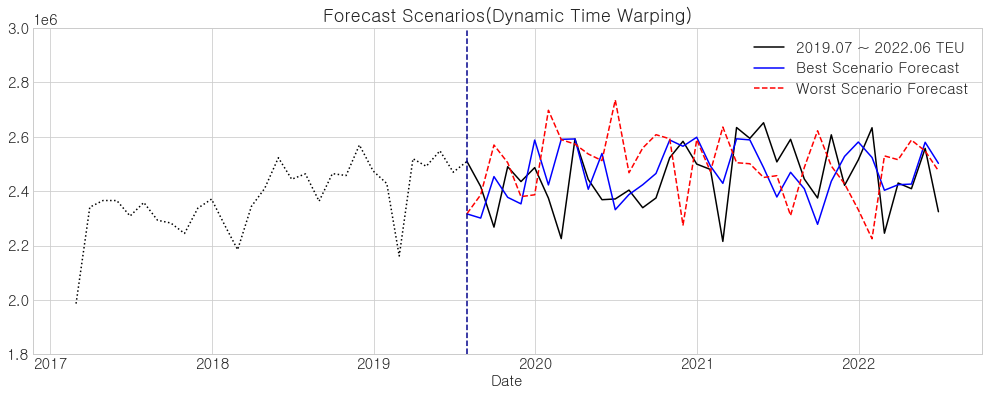

In [118]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Dynamic Time Warping)',fontsize=18)
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[205:235], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[234:], 'black', label='2019.07 ~ 2022.06 TEU')
plt.plot(df3['25'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['18'],color='red',label='Worst Scenario Forecast',linestyle='dashed')


plt.axvline(x='2019-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [119]:
df3.head()

,12,13,18,21,25
Date,,,,,
2019-07-31,2329891.0,2386970.8,2317247.5,2251408.5,2316477.8
2019-08-31,2471098.5,2302355.2,2386617.0,2298761.0,2300996.5
2019-09-30,2470947.0,2522909.8,2569870.2,2338595.0,2453670.8
2019-10-31,2375121.2,2549877.0,2504931.2,2428727.5,2377358.0
2019-11-30,2473806.5,2453758.0,2379917.5,2420870.2,2353352.8


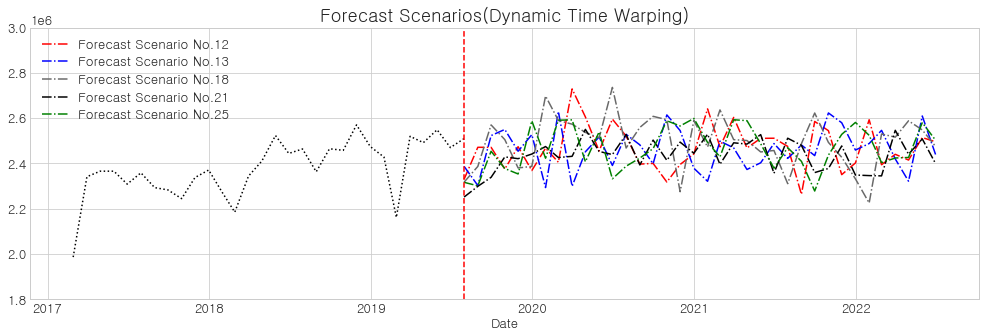

In [120]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Dynamic Time Warping)',fontsize=18)
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[205:235], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[234:], 'black', label='2019.07 ~ 2022.06 TEU')
plt.plot(df3['12'],color='red',label='Forecast Scenario No.12',linestyle='dashdot')
plt.plot(df3['13'],color='blue',label='Forecast Scenario No.13',linestyle='dashdot')
plt.plot(df3['18'],color='dimgrey',label='Forecast Scenario No.18',linestyle='dashdot')
plt.plot(df3['21'],color='black',label='Forecast Scenario No.21',linestyle='dashdot')
plt.plot(df3['25'],color='green',label='Forecast Scenario No.25',linestyle='dashdot')

plt.axvline(x='2019-07-31', color='red',linestyle='dashed')
plt.legend()

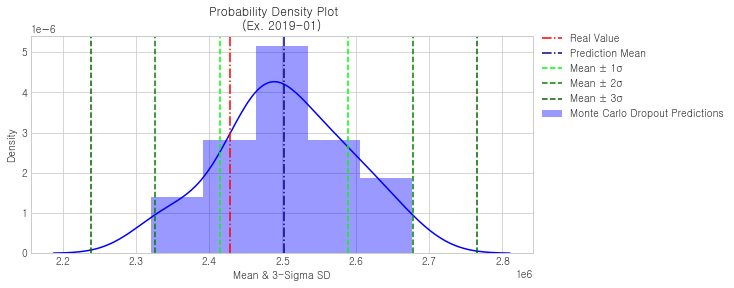

In [68]:
plt.figure(figsize=(9,4))
sns.distplot(df.transpose()[18],color='blue',label='Monte Carlo Dropout Predictions')
plt.axvline(x=2427934, color='red',linestyle='dashdot',label='Real Value')
plt.axvline(x=2502186.2, color='darkblue',linestyle='dashdot',label='Prediction Mean')
plt.axvline(x=2414388.8359375, color='lime',linestyle='dashed',label='Mean ± 1σ')
plt.axvline(x=2589983.6640625, color='lime',linestyle='dashed')
plt.axvline(x=2326591.421875, color='green',linestyle='dashed',label='Mean ± 2σ')
plt.axvline(x=2677781.078125, color='green',linestyle='dashed')
plt.axvline(x=2238794.0078125, color='darkgreen',linestyle='dashed',label='Mean ± 3σ')
plt.axvline(x=2765578.4921875, color='darkgreen',linestyle='dashed')
plt.suptitle('Probability Density Plot')
plt.title('(Ex. 2019-01)')
plt.xlabel("Mean & 3-Sigma SD")
plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left")

In [199]:
df.transpose()[18].quantile(0.9)

2614304.75

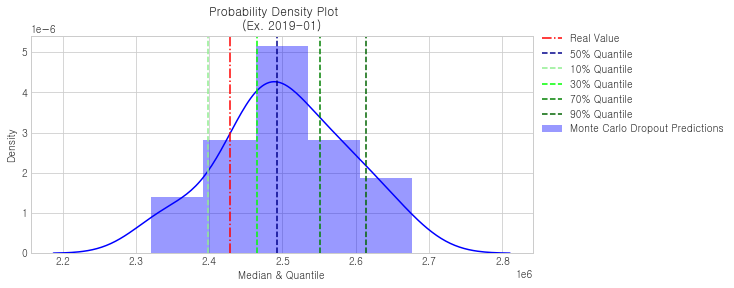

In [65]:
plt.figure(figsize=(9,4))
sns.distplot(df.transpose()[18],color='blue',label='Monte Carlo Dropout Predictions')
plt.axvline(x=2427934, color='red',linestyle='dashdot',label='Real Value')
plt.axvline(x=2492910.875, color='darkblue',linestyle='dashed',label='50% Quantile')
plt.axvline(x=2397732.2, color='lightgreen',linestyle='dashed',label='10% Quantile')
plt.axvline(x=2465831.3, color='lime',linestyle='dashed',label='30% Quantile')
plt.axvline(x=2551215.75, color='green',linestyle='dashed',label='70% Quantile')
plt.axvline(x=2614304.75, color='darkgreen',linestyle='dashed',label='90% Quantile')
plt.suptitle('Probability Density Plot')
plt.title('(Ex. 2019-01)')
plt.xlabel("Median & Quantile")
plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left")

In [58]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2479814.2

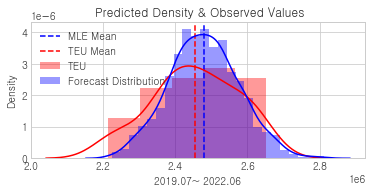

In [59]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.tail(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.tail(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2022.06')
plt.legend()

In [60]:
LL = -np.sum( stats.norm.logpdf(df, loc=test_data.tail(36).reset_index()['TEU'].mean(), scale=test_data.tail(36).reset_index()['TEU'].std() ) )
LL

13995.958487712895

In [51]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

15608.859363921885

In [61]:
LL = -np.sum( stats.norm.logpdf(test_data.tail(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

575.331166716656

In [81]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [83]:
for i in range(0,30):
    print(KL(df[i],test_data.tail(36).reset_index()['TEU']))

1242635.9948365833
1742660.4488599587
511890.66113054566
638823.9401869558
1436360.743115769
1524441.3567297535
2400037.6585759935
1767342.7394599132
2058542.3890600873
1612207.2645295337
332652.7883101484
684464.1350989831
478528.60171904205
1344065.959946071
1050011.8729756451
913719.5354178789
1416070.0230764912
1820246.5633039642
1865724.5253434519
241190.744508654
578128.7715626581
2366398.344028287
1377531.1348916222
1606967.6065525068
600660.9123114457
2787034.8729476547
558369.1177386303
860152.4782268093
3025806.2288604705
2782576.1106731375


In [84]:
a = np.array([1242635.9948365833,
1742660.4488599587,
511890.66113054566,
638823.9401869558,
1436360.743115769,
1524441.3567297535,
2400037.6585759935,
1767342.7394599132,
2058542.3890600873,
1612207.2645295337,
332652.7883101484,
684464.1350989831,
478528.60171904205,
1344065.959946071,
1050011.8729756451,
913719.5354178789,
1416070.0230764912,
1820246.5633039642,
1865724.5253434519,
241190.744508654,
578128.7715626581,
2366398.344028287,
1377531.1348916222,
1606967.6065525068,
600660.9123114457,
2787034.8729476547,
558369.1177386303,
860152.4782268093,
3025806.2288604705,
2782576.1106731375])

In [85]:
np.mean(a)

1387508.1174659545